# Using Eclair for Table and Text Extraction

This notebook demonstrates how to build a streamlined document analysis pipeline by strategically combining a local inference endpoint for layout parsing with powerful NVIDIA NIMs (NVIDIA Inference Microservices) for visual analysis. We'll show how to create an end-to-end workflow that transforms unstructured documents into a queryable knowledge base.


## 1. Introduction

### Models

1. `Eclair`: this is a locally hosted model that we will setup in in the next section 

### Pipeline

1. Given an image of the page, the `Eclair` model runs the segmentation and identifies elements on teh page. 
2. `Eclair` classifies the element roughly as `text`, `table`, or `picture`. 
3. If an item is identified as a `text`, we simply retrieve the contents extracted by Eclair
4. If an item is identified as a `table`, we retrieve the contents exttracted by Eclair. Eclair presents the table as Latex format, so we add an post-processing step to conver that to HTML format for better readability. 
5. If an item is identified as `picture`, we do not do anything about it. 
6. The pipeline saves ouput files 

## 2. Setup and Prerequisites

### Dependencies

First, let's set up the environment. You'll need to install the required Python libraries.


In [19]:
# %pip install requests pillow ipython openai beautifulsoup4 seaborn python-dotenv loguru pymupdf

### GPU Requirements

Eclair can run on 1xL40S, 1xA100 and 1xH100. Smaller GPUs like A10G is also possible but has not been tested. 

### Launch Eclair docker container

1. Log into docker:
	```bash
	docker login nvcr.io
	```
	- User name: `$oauthtoken`
	- Password: your NGC API key. 
2. Pull containers
	```bash
	docker pull nvcr.io/bxlhobqq9vop/eclair-ea/eclair:1.5.0.rc3-35834715
	```
3. Create cache folder 
    ```bash
    export NGC_API_KEY=<PASTE_API_KEY_HERE>
    export LOCAL_NIM_CACHE=~/.cache/nim
    mkdir -p $LOCAL_NIM_CACHE
    chmod 777 -R $LOCAL_NIM_CACHE
    ```
4. Launch container
    ```bash
    docker run -it --rm \
    --gpus "device=0" \
    --shm-size=16GB \
    -e NGC_API_KEY \
    -u 0:0 \
    -v "$LOCAL_NIM_CACHE:/opt/nim/.cache" \
    -p 8002:8000 \
    nvcr.io/bxlhobqq9vop/eclair-ea/eclair:1.5.0.rc3-35834715
    ```    
    Note: 
    1. Since we only need 1 GPU for the Eclair model, we set `device=0` and `cuda:0`
    2. Uvicorn will run on port `8000` inside the container. We map it to host port `8002`
5. Wait until it says
    ```bash
    INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
    ```
6. Test health with: 
    ```bash
    curl http://localhost:8002/v1/health/ready
    ```
    Outputs: 
    ```json
    {"object":"health.response","message":"Service is ready."}
    ```
7. Optional, to view the API docs, you can run the command below, and insepct the results in the JSON file: 
    ```bash
    curl -s http://localhost:8002/openapi.json > eclair_api_docs.json
    ```


### Pipeline Configurations

In [4]:
import os
from datetime import datetime, timezone
import base64
from PIL import Image
from io import BytesIO
import pandas as pd
from IPython.display import display, Markdown, HTML
import requests
from openai import OpenAI
import json

# load environment variables
from dotenv import load_dotenv
load_dotenv()

# --- Configs for the Eclair model ---
DOCKER_HOST = "localhost"  # Updated Docker host IP 10.176.12.87
ECLAIR_PORT = 8002            # Your Docker host port
ECLAIR_ENDPOINT_PATH = "/v1/chat/completions"      # The API endpoint path
ECLAIR_ENDPOINT_URL = f"http://{DOCKER_HOST}:{ECLAIR_PORT}{ECLAIR_ENDPOINT_PATH}"

# --- Configs for the VLM model ---
VLM_PORT = 8000
VLM_ENDPOINT_PATH = "/v1"
VLM_ENDPOINT_URL = f"http://{DOCKER_HOST}:{VLM_PORT}{VLM_ENDPOINT_PATH}"

# --- Output Directory Configuration ---
OUTPUT_DIR = "output_results"
output_annotated_dir = os.path.join(OUTPUT_DIR, "annotated_images")
output_infographics_dir = os.path.join(OUTPUT_DIR, "infographics")
output_json_dir = os.path.join(OUTPUT_DIR, "json_outputs")

In [5]:
def preprocess_image_like_eclair(image, target_w=1648, target_h=2048):
    """
    Place image on the smallest possible "paper" with aspect ratio target_w:target_h.
    Don't downscales the image - keeps original size to prevent blurriness.
    Place the image in the center of a new canvas. 
    This canvas should have a w:h ratio = target_w:target_h. ([3, 1648, 2048] is the input image size of Eclair)
    The canvas should be the smallest possible size that fits the image without downscaling the image. 
    Returns:
        PIL Image on paper with aspect ratio target_w:target_h
    """
    import numpy as np
    
    img_array = np.array(image)
    original_height, original_width = img_array.shape[:2]
    
    # Calculate target aspect ratio (paper ratio)
    target_ratio = target_w / target_h
    
    # Step 1: Determine if we need to scale up (don't scale down)
    scale_for_height = target_h / original_height
    scale_for_width = target_w / original_width
    scale = max(scale_for_height, scale_for_width, 1.0)  # Never less than 1.0
    
    # Calculate image dimensions after potential scaling up
    if scale > 1.0:
        image_width = int(original_width * scale)
        image_height = int(original_height * scale)
        resized_image = image.resize((image_width, image_height), Image.Resampling.LANCZOS)
    else:
        # Keep original size (no downscaling)
        image_width = original_width
        image_height = original_height
        resized_image = image
    
    # Step 2: Calculate smallest paper size with target ratio that fits the image
    # paper_width / paper_height = target_ratio
    # paper_width >= image_width AND paper_height >= image_height
    
    # Option 1: Match height, calculate width
    paper_h_option1 = image_height
    paper_w_option1 = int(paper_h_option1 * target_ratio)
    
    # Option 2: Match width, calculate height  
    paper_w_option2 = image_width
    paper_h_option2 = int(paper_w_option2 / target_ratio)
    
    # Choose the option that fits both dimensions
    if paper_w_option1 >= image_width and paper_h_option1 >= image_height:
        paper_width = paper_w_option1
        paper_height = paper_h_option1
    else:
        paper_width = paper_w_option2
        paper_height = paper_h_option2
    
    # Step 3: Create paper with white background
    resized_array = np.array(resized_image)
    
    # Handle grayscale images
    if len(resized_array.shape) == 2:
        resized_array = np.stack([resized_array] * 3, axis=-1)
    
    # Create white paper
    paper_array = np.ones((paper_height, paper_width, 3), dtype=np.uint8) * 255
    
    # Center the image on the paper
    pad_left = (paper_width - image_width) // 2
    pad_top = (paper_height - image_height) // 2
    
    paper_array[pad_top:pad_top+image_height, pad_left:pad_left+image_width] = resized_array
    
    # Create final image and set DPI to 300
    result_image = Image.fromarray(paper_array)
    result_image.info['dpi'] = (300, 300)
    
    return result_image



def load_and_resize_image(image_path, save=False, save_dir=None):
    """
    Load an image from the given path and resize it to 2048x1648 (height x width).
    
    Args:
        image_path (str): Path to the input image
        save (bool): If True, save the resized image with a '_resized' suffix
        
    Returns:
        str: Path to the resized image (either saved or original path)
    """
    from PIL import Image
    import os
    
    # Load the image, convert to RGB if necessary
    img = Image.open(image_path)

    # Resize to (width, height) - PIL uses (width, height) format
    # Target: height=2048, width=1648
    # target_size = (1648, 2048)  # (width, height) for PIL
    # resized_img = img.resize(target_size ,Image.Resampling.LANCZOS)
    resized_img = preprocess_image_like_eclair(img)

    if save:
        # Create resized file path
        path_parts = os.path.splitext(image_path)
        # if save_dir is not None, use it
        if save_dir is not None:
            # get base file name
            base_name = os.path.basename(image_path)
            # split the file name into name and extension
            name, ext = os.path.splitext(base_name)
            resized_path = os.path.join(save_dir, f"{name}_resized{ext}")
        else:
            resized_path = f"{path_parts[0]}_resized{path_parts[1]}"
        
        # Save the resized image
        resized_img.save(resized_path)
        return resized_path
    else:
        return image_path


In [6]:
# test resize funct4ion
# result = load_and_resize_image("/home/ubuntu/nim-dev/models/nemo-retriever-parse/output_results/converted_images/soa_1/fitz/soa_1_page_1_fitz.png"  , save=True, save_dir="output_results/resized_images")
# result

## 3. Collect Example Document Images

In this step, we collect the example images we want to analyze in a list 

In [7]:
import os, re, itertools
from glob import glob
from pathlib import Path
import shutil

# Root of the notebook
WORKSPACE_ROOT = Path.cwd()
# Root of the converted imaages folder, from step 1 notebook
DATA_ROOT = WORKSPACE_ROOT / "output_results" 

# Patterns covering both pipelines and direct converted images
# adjust accordingly to match the location of your converted images
PATTERNS = [
    str(DATA_ROOT / "converted_images" / "soa_1" / "fitz" / "*.png")
    # str(DATA_ROOT / "converted_images" / "page_7" / "fitz"/ "*.png")
]

# get all the paths of the converted images
all_paths_abs = []
for pat in PATTERNS:
    all_paths_abs.extend(glob(pat, recursive=True))

# Dedup + natural sort (so _page_2_ comes before _page_10_)
def _natural_key(s: str):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]
all_paths_abs = sorted(set(all_paths_abs), key=_natural_key)

# create a folder to save the resized images
save_dir = DATA_ROOT / "resized_images"
if save_dir is not None:
    # delete the file if it exists
    if os.path.exists(save_dir):
        # delete directory and all its contents
        shutil.rmtree(save_dir)
    os.makedirs(save_dir)

# add resized images to the list
ALLOWED_PAGE_PATHS = []
for p in all_paths_abs:
    resized_fp = load_and_resize_image(p, save=True, save_dir=save_dir)
    # convert to repo‑relative paths
    rel = os.path.relpath(resized_fp, WORKSPACE_ROOT).replace("\\", "/")
    ALLOWED_PAGE_PATHS.append(rel)

# sort the paths
ALLOWED_PAGE_PATHS = sorted(set(ALLOWED_PAGE_PATHS), key=_natural_key)

print(f"✅ Collected a total of {len(ALLOWED_PAGE_PATHS)} image pages")
print("Here are the first 10 input image paths:")
for sample in itertools.islice(ALLOWED_PAGE_PATHS, 10):
    print(" -", sample)

✅ Collected a total of 1 image pages
Here are the first 10 input image paths:
 - output_results/resized_images/soa_1_page_1_fitz_resized.png


## 4. The Core Pipeline in Action

Now, let's walk through the code that powers our pipeline.


### Helper Functions

This block encapsulates our pipeline's logic. 

1. `call_eclair_inference` handles communication with our local layout analysis engine. 
2. `latex_table_to_html` provides advanced conversion of LaTeX tables to HTML. 
3. Finally, `draw_annotations` visualizes the results by drawing labeled bounding boxes.


#### Eclair related helpers

The Eclair model will return a string, with bbox and extracted context. We need to parse it. 

In [8]:
import re
from typing import List, Dict, Any, Union

_PATTERN = re.compile(
    r"<x_(\d+(?:\.\d+)?)><y_(\d+(?:\.\d+)?)>(.*?)<x_(\d+(?:\.\d+)?)><y_(\d+(?:\.\d+)?)><class_([^>]+)>",
    re.DOTALL,
)

def parse_content_to_blocks(content: str) -> List[Dict[str, Any]]:
    transformed_data: List[Dict[str, Any]] = []
    for xmin, ymin, text, xmax, ymax, cls in _PATTERN.findall(content):
        transformed_data.append({
            "type": cls,  # same role as old 'category'
            "text": text.strip(),
            "bbox": {
                "xmin": float(xmin),
                "ymin": float(ymin),
                "xmax": float(xmax),
                "ymax": float(ymax),
            },
        })
    return transformed_data

def parse_response(resp: Union[List, Dict]) -> List[Dict[str, Any]]:
    content = resp['choices'][0]["message"]["content"]
    return parse_content_to_blocks(content)

def encode_file_to_base64(image_path: str):
    with open(image_path, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode('utf-8')

    ext = os.path.splitext(image_path)[1].lower()
    if ext in ('.jpg', '.jpeg'):
        mime = 'image/jpeg'
    elif ext == '.png':
        mime = 'image/png'
    else:
        # raise warning
        mime = 'image/' + ext
        print(f"Warning: Imeage extension is {ext}. Not all image types are supported. It might be best to convert to .png, .jpg, .jpeg instead. For now we will try to encode it as {mime}")

    return "data:" + mime + ";base64," + image_b64

def call_eclair_inference(image_path: str, temperature: float = 0.5):
    """
    Sends an image to the local Docker inference endpoint and transforms the
    output to the format expected by the rest of the script.
    Args:
        image_path (str): The path to the image to send to the Docker endpoint.
    Returns:
        list: A list of dictionaries, each representing a block in the image.
    """
    image_filename = os.path.basename(image_path)

    # convert to base64 encoded image
    image_b64 = encode_file_to_base64(image_path)
    print(f"    - Sending {image_filename} to Docker endpoint: {ECLAIR_ENDPOINT_URL}")

    try:
        headers = {
            'accept': 'application/json',
            'Content-Type': 'application/json'
        }
        data = {
            "model": "nvidia/nemotron-parse",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": image_b64
                            }
                        }
                    ]
                }
            ],
            "temperature": temperature
        }

        response = requests.post(ECLAIR_ENDPOINT_URL, headers=headers, json=data, timeout=180)
        response.raise_for_status()  # Raise an exception for bad status codes
        response_json = response.json()
        transformed_data = parse_response(response_json)
        return transformed_data

    except requests.exceptions.RequestException as e:
        print(f"    - ERROR: Could not connect to Docker endpoint at {ECLAIR_ENDPOINT_URL}. Please ensure it is running. Details: {e}")
        return None
    except Exception as e:
        print(f"    - An unexpected error occurred during Docker inference: {e}")
        return None

In [9]:
# # Test eclair with a single image
# parsed_data = call_eclair_inference(
#     image_path = "output_results/converted_images/darby-et-al-2024_page_4/darby-et-al-2024_page_4.png" 
# )

# print(json.dumps(parsed_data, indent=4))

#### Drawing related helpers

In [10]:
import io
import re
from bs4 import BeautifulSoup
from PIL import ImageDraw, ImageFont

# Define the colors for each class. This is used to color the bounding boxes in the output image.
CLASS_COLORS = {
    'Text': '#4CAF50', 'Title': '#D32F2F', 'Section-header': '#E91E63',
    'List-item': '#1976D2', 'Table': '#03A9F4', 'Picture': '#6D4C41',
    'Caption': '#607D8B', 'Formula': '#FF9800', 'Page-header': '#BDBDBD',
    'Page-footer': '#BDBDBD', 'Footnote': '#00BCD4', 'Bibliography': '#512DA8',
    'TOC': '#FFC107', 'DEFAULT': '#9E9E9E'
}



def get_text_color(hex_color):
    """
    Gets the text color for a given hex color. Used to determine the color of the text in the bounding box.
    Args:
        hex_color (str): The hex color to get the text color for.
    Returns:
        str: The text color.
    """
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    luminance = (0.2126 * r + 0.7152 * g + 0.0722 * b)
    return "#000000" if luminance > 140 else "#FFFFFF"

def draw_annotations(image: Image.Image, extraction_data: list):
    """
    Draws the annotations on the image.
    Args:
        image (Image.Image): The image to draw the annotations on.
        extraction_data (list): The data to draw the annotations on.
    Returns:
        Image.Image: The image with the annotations drawn on it.
    """

    draw = ImageDraw.Draw(image)
    width, height = image.size
    
    box_thickness = max(3, int(width / 600))
    font_size = max(20, int(width / 100))
    try:
        font = ImageFont.truetype("Arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    for i, item in enumerate(extraction_data):
        bbox = item.get("bbox")
        if not bbox or bbox.get("xmax", 0) < bbox.get("xmin", 0) or bbox.get("ymax", 0) < bbox.get("ymin", 0):
            continue

        item_type = item.get("type", "DEFAULT")
        color = CLASS_COLORS.get(item_type, CLASS_COLORS['DEFAULT'])
        text_color = get_text_color(color)

        left, top, right, bottom = (
            bbox["xmin"] * width, 
            bbox["ymin"] * height, 
            bbox["xmax"] * width, 
            bbox["ymax"] * height
        )
        # this `transform_bbox_to_original` function may also be used to remap the bbox to the original image size , if you do not resize the image before inputting it into Eclair. 
        # however it is not as reliable as trasnforming the input image to the appropriate size for Eclair. 
        # if you already resized the image, then you no longer need to use this function
        # left, top, right, bottom = transform_bbox_to_original(bbox, width, height)
        draw.rectangle([left, top, right, bottom], outline=color, width=box_thickness)

        label = f"ID: {i} | {item_type}"
        if item_type == 'Picture':
            label = f"ID: {i} | Picture:{item.get('sub_type', 'general')}"

        text_bbox = draw.textbbox((0, 0), label, font=font)
        text_height = text_bbox[3] - text_bbox[1]
        text_width = text_bbox[2] - text_bbox[0]

        label_y_pos = top - text_height - (box_thickness * 2)
        if label_y_pos < 0: label_y_pos = top + (box_thickness * 2)

        label_bg = (left, label_y_pos, left + text_width + 10, label_y_pos + text_height + 10)
        draw.rectangle(label_bg, fill=color)
        draw.text((left + 5, label_y_pos + 5), label, fill=text_color, font=font)

    return image

# --- Advanced LaTeX Table to HTML Conversion Functions ---
def skip_whitespace(text, i):
    """Advance index i past any whitespace."""
    while i < len(text) and text[i].isspace():
        i += 1
    return i

def parse_braced_argument(text, i):
    """
    Given text and an index i that should point at an opening '{',
    return a tuple (argument_content, new_index) where argument_content is the full
    string inside the balanced braces and new_index is the position just after the matching '}'.
    Args:
        text (str): The text to parse.
        i (int): The index to start parsing at.
    Returns:
        tuple: A tuple containing the argument content and the new index.
    """
    if i >= len(text) or text[i] != '{':
        raise ValueError("Expected '{' at position {}".format(i))
    i += 1  # skip the opening brace
    start = i
    level = 1
    while i < len(text) and level > 0:
        if text[i] == '{':
            level += 1
        elif text[i] == '}':
            level -= 1
        i += 1
    if level != 0:
        raise ValueError("Unbalanced braces starting at position {}".format(start-1))
    # The argument content is from start to i-1 (excluding the closing brace)
    return text[start:i-1], i

def parse_command(text, i):
    """
    Parse a \multirow or \multicolumn command starting at index i.
    This function assumes the command has exactly three braced arguments.

    It processes each argument recursively. For the third argument, after recursive processing,
    it replaces any unescaped & with \&.
    
    Args: 
        text (str): The text to parse.
        i (int): The index to start parsing at.
    Returns:
        tuple: A tuple containing the command text and the new index.
    """
    # Determine which command we have.
    if text.startswith(r"\multirow", i):
        command_name = r"\multirow"
        i += len(r"\multirow")
    elif text.startswith(r"\multicolumn", i):
        command_name = r"\multicolumn"
        i += len(r"\multicolumn")
    else:
        raise ValueError("Expected \\multirow or \\multicolumn at position {}".format(i))

    # Skip whitespace between the command name and the first argument.
    i = skip_whitespace(text, i)
    args = []
    # Expect exactly three arguments
    for arg_index in range(3):
        if i >= len(text) or text[i] != '{':
            raise ValueError("Expected '{{' for argument {} at position {}".format(arg_index+1, i))
        arg_content, i = parse_braced_argument(text, i)
        # Process the content recursively to catch nested commands
        processed_arg = clean_multi_cells(arg_content)
        if arg_index == 2:
            # For the cell text (third argument), replace any unescaped &
            processed_arg = re.sub(r'(?<!\\)&', r'\\&', processed_arg)
        args.append(processed_arg)
        # Only skip whitespace between arguments, not after the last one.
        if arg_index < 2:
            i = skip_whitespace(text, i)
    # Reconstruct the full command with its three arguments
    command_text = f"{command_name}{{{args[0]}}}{{{args[1]}}}{{{args[2]}}}"
    return command_text, i

def clean_multi_cells(text):
    """
    Process an arbitrary LaTeX text string and look for occurrences of \multirow or \multicolumn commands.
    When found, the command is parsed (handling nested braces and nested commands) and its third argument is fixed.

    Args:
        text (str): The text to process.
    Returns:
        str: The processed text.
    """
    result = []
    i = 0
    while i < len(text):
        # Find next occurrence of either command.
        idx_multi = text.find(r"\multirow", i)
        idx_multiC = text.find(r"\multicolumn", i)

        # Determine the next index among the two (if any)
        if idx_multi == -1 and idx_multiC == -1:
            result.append(text[i:])
            break
        if idx_multi == -1:
            next_idx = idx_multiC
        elif idx_multiC == -1:
            next_idx = idx_multi
        else:
            next_idx = min(idx_multi, idx_multiC)

        # Append text before the command (preserving any whitespace)
        result.append(text[i:next_idx])
        # Process the command starting at next_idx
        command_text, new_index = parse_command(text, next_idx)
        result.append(command_text)
        i = new_index
    return ''.join(result)

def parse_brace(s, pos):
    """
    Given a string s and an index pos pointing to an opening '{',
    returns a tuple (content, new_pos) where content is the string
    between the matching braces (handling nested braces) and new_pos is
    the index just after the closing '}'.

    Args:
        s (str): The string to parse.
        pos (int): The index to start parsing at.
    Returns:
        tuple: A tuple containing the content and the new index.
    """
    if pos >= len(s) or s[pos] != '{':
        raise ValueError("Expected '{{' at position %d" % pos)
    pos += 1  # skip the opening brace
    content = ""
    depth = 1
    while pos < len(s) and depth:
        char = s[pos]
        if char == '{':
            depth += 1
            content += char
        elif char == '}':
            depth -= 1
            if depth:
                content += char
        else:
            content += char
        pos += 1
    if depth != 0:
        raise ValueError("Unmatched '{{' in string.")
    return content, pos

def parse_command_merge(s, pos):
    """
    Parse a multirow or multicolumn command starting at s[pos]. If the content
    of the command contains a nested command, then recursively parse the inner
    command and merge its parameters with the outer ones. The merging is done
    so that the outer multirow's parameters (e.g. rowspan and width) are kept
    while the inner command's parameters (e.g. colspan, alignment) and its innermost
    content are returned.

    Args: 
        s (str): The string to parse.
        pos (int): The index to start parsing at.

    Returns a tuple (merged_dict, new_pos) where merged_dict is a dictionary
    containing the combined parameters and new_pos is the updated index after
    parsing the command.
    """
    if s.startswith(r"\multirow", pos):
        newpos = pos + len(r"\multirow")
        # Parse the three required arguments for multirow: rowspan, width, and content.
        rowspan, newpos = parse_brace(s, newpos)
        width, newpos = parse_brace(s, newpos)
        content, newpos = parse_brace(s, newpos)
        # Look for a nested command (either \multirow or \multicolumn) in the content.
        index_mr = content.find(r"\multirow")
        index_mc = content.find(r"\multicolumn")
        if index_mr == -1 and index_mc == -1:
            # No nested command found; return this command's details.
            return {"rowspan": rowspan.strip(), "width": width.strip(), "content": content.strip()}, newpos
        else:
            # At least one nested command is present. Pick the first occurrence.
            indices = [i for i in (index_mr, index_mc) if i != -1]
            first_index = min(indices)
            # Parse the inner (nested) command from within the content.
            inner, _ = parse_command_merge(content, first_index)
            # Merge: keep the outer multirow's parameters and add the inner ones.
            merged = {"rowspan": rowspan.strip(), "width": width.strip()}
            merged.update(inner)
            return merged, newpos

    elif s.startswith(r"\multicolumn", pos):
        newpos = pos + len(r"\multicolumn")
        # Parse the three arguments for multicolumn: colspan, alignment, and content.
        colspan, newpos = parse_brace(s, newpos)
        alignment, newpos = parse_brace(s, newpos)
        content, newpos = parse_brace(s, newpos)
        # Look for a nested command in the content.
        index_mr = content.find(r"\multirow")
        index_mc = content.find(r"\multicolumn")
        if index_mr == -1 and index_mc == -1:
            return {"colspan": colspan.strip(), "alignment": alignment.strip(), "content": content.strip()}, newpos
        else:
            indices = [i for i in (index_mr, index_mc) if i != -1]
            first_index = min(indices)
            inner, _ = parse_command_merge(content, first_index)
            merged = {"colspan": colspan.strip(), "alignment": alignment.strip()}
            merged.update(inner)
            return merged, newpos

    # Not a recognized command starting at pos.
    return None, pos

def extract_merged_commands(s):
    """
    Scan through the LaTeX string s and extract merged multirow/multicolumn commands.
    For each command found, if there is nesting the parser merges the outer and inner
    parameters so that the final result includes both the rowspan (or width) and the colspan
    (or alignment) along with the innermost content.

    Args: 
        s (str): The string to parse.
    Returns a list of dictionaries.
    """
    pos = 0
    results = []
    while pos < len(s):
        if s[pos] == '\\':
            res, newpos = parse_command_merge(s, pos)
            if res is not None:
                results.append(res)
                pos = newpos
                continue
        pos += 1
    return results

def remove_tags(html, tags_to_remove):
    """
    Removes the specified tags from the HTML string.

    Args:
        html (str): The HTML string to remove tags from.
        tags_to_remove (list): A list of tag names to remove.
    Returns:
        str: The HTML string with the specified tags removed.
    """
    soup = BeautifulSoup(html, "html.parser")
    # Loop through the tags to remove
    for tag_name in tags_to_remove:
        for tag in soup.find_all(tag_name):
            # Move the children of the tag to the parent tag
            tag.unwrap()  # This removes the tag but keeps its contents
    # Return the modified HTML as a string
    return str(soup)

def convert_th_to_td(html):
    """Replace all th tags with td tags
    """
    soup = BeautifulSoup(html)
    for th_tag in soup.find_all('th'):
        th_tag.name = 'td'
    return str(soup)

def replace_italic(text):
    pattern = re.compile(r'(?<!\\)_(.*?)(?<!\\)_')

    def italic_replacer(match):
        # Get the text inside the underscores.
        content = match.group(1)
        # Remove the escape (backslash) from any escaped underscores inside.
        content = content.replace(r'\_', '_')
        return f"<i>{content}</i>"

    # Replace all occurrences of the pattern using the replacer function.
    return pattern.sub(italic_replacer, text)

def replace_bold(text):
    pattern = re.compile(r'(?<!\\)\*\*(.*?)(?<!\\)\*\*')

    def bold_replacer(match):
        content = match.group(1)
        # Unescape any escaped asterisks within the captured text.
        content = content.replace(r'\*', '*')
        return f"<b>{content}</b>"

    return pattern.sub(bold_replacer, text)

def latex_table_to_html(latex_str):
    # Pattern to match the entire tabular environment
    table_pattern = r'\\begin{tabular}{([^}]*)}\s*(.*?)\\end{tabular}'

    def process_cell(cell):
        # Clean up cell content
        cell = cell.strip()

        out = extract_merged_commands(cell)
        if len(out) > 0:
            cell = process_cell(out[0]["content"])["content"]
            rowspan = int(out[0].get("rowspan", "1"))
            colspan = int(out[0].get("colspan", "1"))
            return {
                "content": cell,
                "colspan": colspan,
                "rowspan": rowspan
            }

        # Replace latex and markdown formatting with HTML tags
        cell = re.sub(r'\$([^$]*)\$', r'\1', cell)  # Remove math mode
        cell = re.sub(r'\\textbf{([^}]*)}', r'<b>\1</b>', cell)  # Convert latex bold
        cell = re.sub(r'\\textit{([^}]*)}', r'<i>\1</i>', cell)  # Convert latex italic
        cell = replace_italic(cell)
        cell = replace_bold(cell)

        cell = cell.replace("\\$", "$").replace("\\%", "%").replace("\\newline", " ").replace("\\textless", "<").replace("\\textgreater", ">").replace("\\*", "*").replace("\\_", "_").replace("\\\\", "\\")

        # Replace \& with & in the cell text
        cell = cell.replace(r'\\&', '&')

        return {
            'content': cell,
            'colspan': 1,
            'rowspan': 1
        }

    def split_row(input_string):
        # Use a regular expression to split on '&' that is not preceded by a backslash
        return re.split(r'(?<!\\)&', input_string)

    def convert_table(match):
        # Extract table content
        format_spec, content = match.groups()

        # Start building HTML table
        html = ['<table>']

        # Track cells for multirow
        multirow_tracker = set()

        # Process rows
        rows = re.split(r'\\\\', content)
        current_row = 0

        for row in rows:
            if not row.strip():
                continue

            row = row.strip()

            # Skip \hline
            if '\\hline' in row:
                row = row.replace('\\hline', '')
                if not row.strip():
                    continue

            row = clean_multi_cells(row)

            # Process cells
            cells = split_row(row)
            processed_cells = [process_cell(cell) for cell in cells]

            # Build row HTML
            html.append('  <tr>')
            current_col = 0

            # Handle cells in this row
            for cell in processed_cells:

                # Add the current cell
                attrs = []
                if cell['colspan'] > 1:
                    attrs.append(f'colspan="{cell["colspan"]}"')
                if cell['rowspan'] > 1:
                    attrs.append(f'rowspan="{cell["rowspan"]}"')
                    # Add to tracker for future rows
                    for r in range(current_row + 1, current_row + cell['rowspan']):
                        for c in range(current_col, current_col + cell['colspan']):
                            multirow_tracker.add((r, c))

                if (current_row, current_col) in multirow_tracker and cell["content"] == "" and cell["colspan"] == 1 and cell["rowspan"] == 1:
                    current_col += cell['colspan']
                    continue

                attr_str = ' ' + ' '.join(attrs) if attrs else ''
                cell_tag = 'td'
                html.append(f'    <{cell_tag}{attr_str}>{cell["content"]}</{cell_tag}>')

                current_col += cell['colspan']

            html.append('  </tr>')
            current_row += 1

        html.append('</table>')
        return '\n'.join(html)

    # Convert all tabular environments in the input
    return re.sub(table_pattern, convert_table, latex_str, flags=re.DOTALL)


<>:124: SyntaxWarning: invalid escape sequence '\m'
<>:169: SyntaxWarning: invalid escape sequence '\m'
<>:124: SyntaxWarning: invalid escape sequence '\m'
<>:169: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_371351/356512300.py:124: SyntaxWarning: invalid escape sequence '\m'
  Parse a \multirow or \multicolumn command starting at index i.
/tmp/ipykernel_371351/356512300.py:169: SyntaxWarning: invalid escape sequence '\m'
  Process an arbitrary LaTeX text string and look for occurrences of \multirow or \multicolumn commands.


### Executing the Pipeline

This cell is the pipeline's orchestrator. 

1. It iterates through each image path, calling the local Docker endpoint for initial layout parsing. 
2. All results are aggregated into structured JSON objects. 
3. `draw_annotations` is used to create a visualized output for each page. 
4. Additionally, it shows the HTML rendered content of detected tables. 


In [11]:
# the input file paths for the images.
ALLOWED_PAGE_PATHS

['output_results/resized_images/soa_1_page_1_fitz_resized.png']

🔍 Processing Page 1/1: output_results/resized_images/soa_1_page_1_fitz_resized.png
[Stage 1] Calling local parser for layout analysis...
    - Sending soa_1_page_1_fitz_resized.png to Docker endpoint: http://localhost:8002/v1/chat/completions


[Stage 1] Found 6 document objects.

Displaying final annotated page:


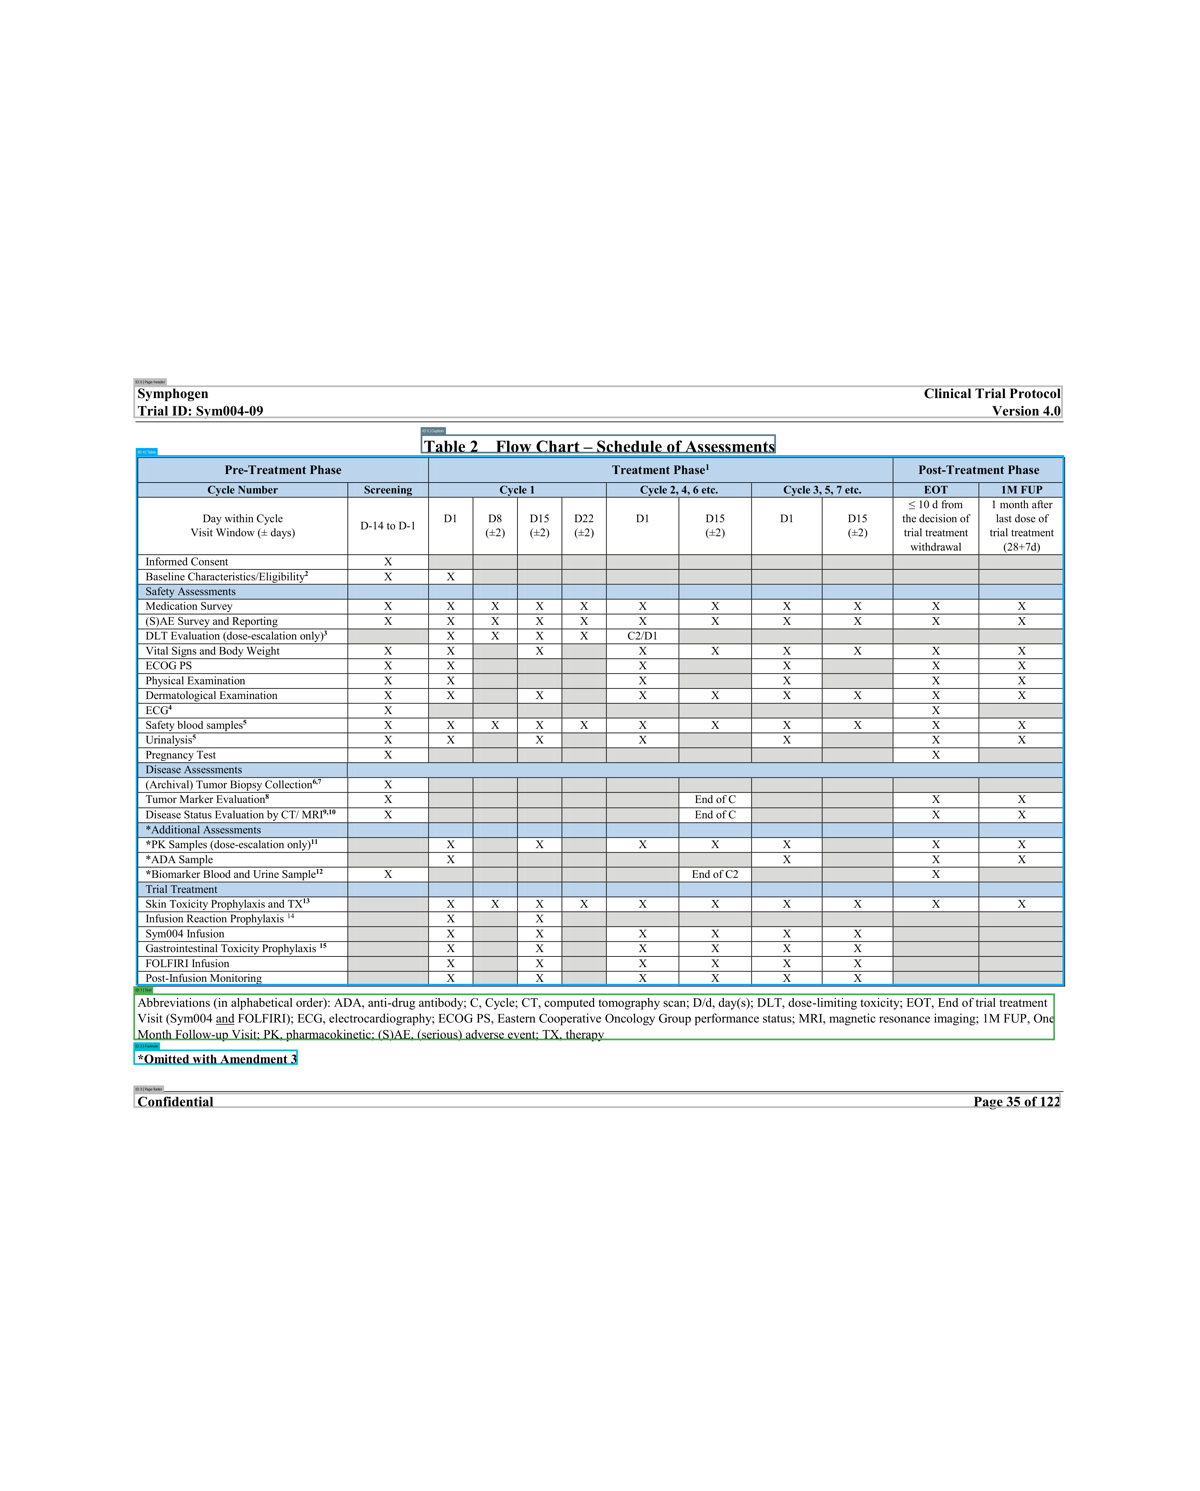

[Stage 2] Found Table (ID: 4). Parsing and reconstructing table...
- Cropped table patch for context:


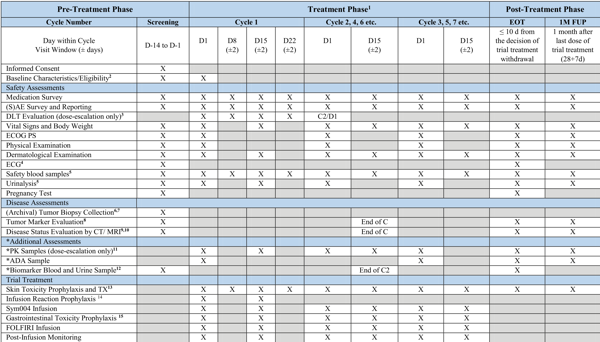

- Reconstructed HTML Table:


Annotated image saved as output_results/annotated_images/soa_1_page_1_fitz_resized_annotated.png
JSON data saved as output_results/json_outputs/soa_1_page_1_fitz_resized_extracted.json
--------------------------------------------------------------------------------
Processing complete.


In [12]:
# make output folders
for d in [output_annotated_dir, output_infographics_dir, output_json_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

# initialize empty list to store all document data
all_document_data = []
total_pages = len(ALLOWED_PAGE_PATHS)

# iterate through each image path
for i, image_path_str in enumerate(ALLOWED_PAGE_PATHS):
    page_count = i + 1
    print(f"🔍 Processing Page {page_count}/{total_pages}: {image_path_str}")

    # if the file does not exist, fail silently
    if not os.path.exists(image_path_str):
        print(f" - ❌ ERROR: File not found. Skipping.")
        continue

    # read the image
    page_image = Image.open(image_path_str)
    filename_stem = os.path.splitext(os.path.basename(image_path_str))[0]

    # Stage 1: Call the Docker inference function for layout analysis
    print("[Stage 1] Calling local parser for layout analysis...")
    extracted_data = call_eclair_inference(
        image_path_str, 
        temperature=0
    )

    page_num_str = ''.join(filter(str.isdigit, filename_stem.split('_')[-1]))
    page_num = int(page_num_str) if page_num_str.isdigit() else 0

    # initialize the page entry to store the extracted data
    page_entry = {
        "source_document": image_path_str,
        "source_page_number": page_num,
        "processing_timestamp_utc": datetime.now(timezone.utc).isoformat(),
        "status": "",
        "content": []
    }

    # if the layout extraction failed, append the failed entry and continue
    if extracted_data is None:
        page_entry["status"] = "Layout extraction failed (Docker Inference)"
        all_document_data.append(page_entry) # Append failed entry and continue
        continue

    # if the layout extraction was successful, append the successful entry
    else:
        page_entry["status"] = "Layout extraction successful (Docker Inference)"
        print(f"[Stage 1] Found {len(extracted_data)} document objects.")

    # Draw annotations and save the visualized output
    annotated_image = draw_annotations(page_image.copy(), extracted_data)
    output_filename = os.path.join(output_annotated_dir, f"{filename_stem}_annotated.png")
    annotated_image.save(output_filename)
    print("\nDisplaying final annotated page:")
    display(annotated_image.resize((1200, int(1200 * annotated_image.height / annotated_image.width))))

    # Stage 2: Deep Analysis with llama-3.1-nemotron-nano-vl-8b-v1
    # iterate through each item in the extracted data
    for item_idx, item in enumerate(extracted_data):

        # initialize the item metadata
        item_metadata = {
            "extraction_id": item_idx,
            "metadata": {"source_page": page_num, "type": item.get("type"), "bbox": item.get("bbox")},
            "confidence": "N/A",
            "extraction_status": "Success",
            "data": {}
        }
        item_type = item.get("type")

        # if the item is a picture (not a table), just save the cropped image as it is 
        if item_type == "Picture":
            print(f"[Stage 2] Found Picture (ID: {item_idx}). Triggering Specialist VLM...")
            bbox = item.get("bbox")
            if not bbox or not all(k in bbox for k in ['xmin', 'ymin', 'xmax', 'ymax']) or bbox["xmax"] <= bbox["xmin"] or bbox["ymax"] <= bbox["ymin"]:
                item_metadata["extraction_status"] = "Failed (Invalid Bounding Box)"
                page_entry["content"].append(item_metadata)
                continue

            # Crop the image based on bounding box
            width, height = page_image.size
            crop_box = (max(0, bbox["xmin"] * width), max(0, bbox["ymin"] * height), min(width, bbox["xmax"] * width), min(height, bbox["ymax"] * height))

            if crop_box[0] >= crop_box[2] or crop_box[1] >= crop_box[3]:
                item_metadata["extraction_status"] = "Failed (Zero-Area Bounding Box)"
                page_entry["content"].append(item_metadata)
                continue

            cropped_img = page_image.crop(crop_box)
            print(f"- Cropped image: ")
            display(cropped_img.resize((200, int(200 * cropped_img.height / cropped_img.width))))

        # if the item is a table, parse the extraction results from Eclair, and reconstruct the table by converting LaTeX to HTML
        elif item_type == "Table":
            print(f"[Stage 2] Found Table (ID: {item_idx}). Parsing and reconstructing table...")

            # Show the detected table patch for context
            bbox = item.get("bbox")
            if bbox:
                width, height = page_image.size
                crop_box = (max(0, bbox["xmin"] * width), max(0, bbox["ymin"] * height), min(width, bbox["xmax"] * width), min(height, bbox["ymax"] * height))
                if crop_box[0] < crop_box[2] and crop_box[1] < crop_box[3]:
                    cropped_table_img = page_image.crop(crop_box)
                    print(f"- Cropped table patch for context:")
                    display(cropped_table_img.resize((600, int(600 * cropped_table_img.height / cropped_table_img.width))))

            latex_code = item.get("text", "")
            try:
                if not latex_code:
                    raise ValueError("Empty LaTeX content for table")

                # Use the new advanced converter
                html_table = latex_table_to_html(latex_code)

                if "<table>" not in html_table:
                    raise ValueError("tabular environment not found or conversion failed.")

                # Display the result
                print(f"- Reconstructed HTML Table:")
                display(HTML(html_table))

                # Store the final HTML in the results
                item_metadata["data"] = {"type": "tabular", "content_html": html_table}

            except Exception as e:
                print(f"- ERROR: Failed to parse table data. Details: {e}")
                item_metadata["extraction_status"] = "Failed (Table Parsing Error)"
                item_metadata["data"] = {"error": f"Could not parse content: {e}", "raw_content": latex_code}
        
        # Fallback for any other type, like 'Text'
        else:
            item_metadata["data"] = {"type": "textual", "content": item.get("text", "")}

        page_entry["content"].append(item_metadata)

    # Save the individual JSON data for the page
    json_filename = os.path.join(output_json_dir, f"{filename_stem}_extracted.json")
    with open(json_filename, 'w') as f:
        json.dump(page_entry, f, indent=4)

    all_document_data.append(page_entry)
    print(f"Annotated image saved as {output_filename}")
    print(f"JSON data saved as {json_filename}")
    print("-" * 80)

print(f"Processing complete.")

### Caveats

1. Eclair sometimes will fail to segment properly (e.g. did not put a bounding box over an element)
2. When eclair parsed tables are not always 100% accurate. It might struggle with tables that has complex layout (e.g. a lot of merged columns/rows, table within a table, etc). In such case, alternative approaches using VLM for table question-answering could be considered as opposed to trying to extract all contents of the table. 
2. Step_3 notebook talks about 2 ways to benchmark table extraction accuracy: through TEDS score (an unbiased metrics) or Q&A accuracy (biased metrics due to human-designed question-answer set. )


## 5. Understanding the output files


Inside the `output_results` folder: 

- `annotate_images`: This folder contains images with bounding boxes produced by Eclair. The name of the file is `<original_image_file_name_annotated>.<image_format>`
- `inforgraphics`:  This folder contains the results from the VLM extraction.
- `json_output`: This folder contains results from the Eclair extracion

### Display an annotated image

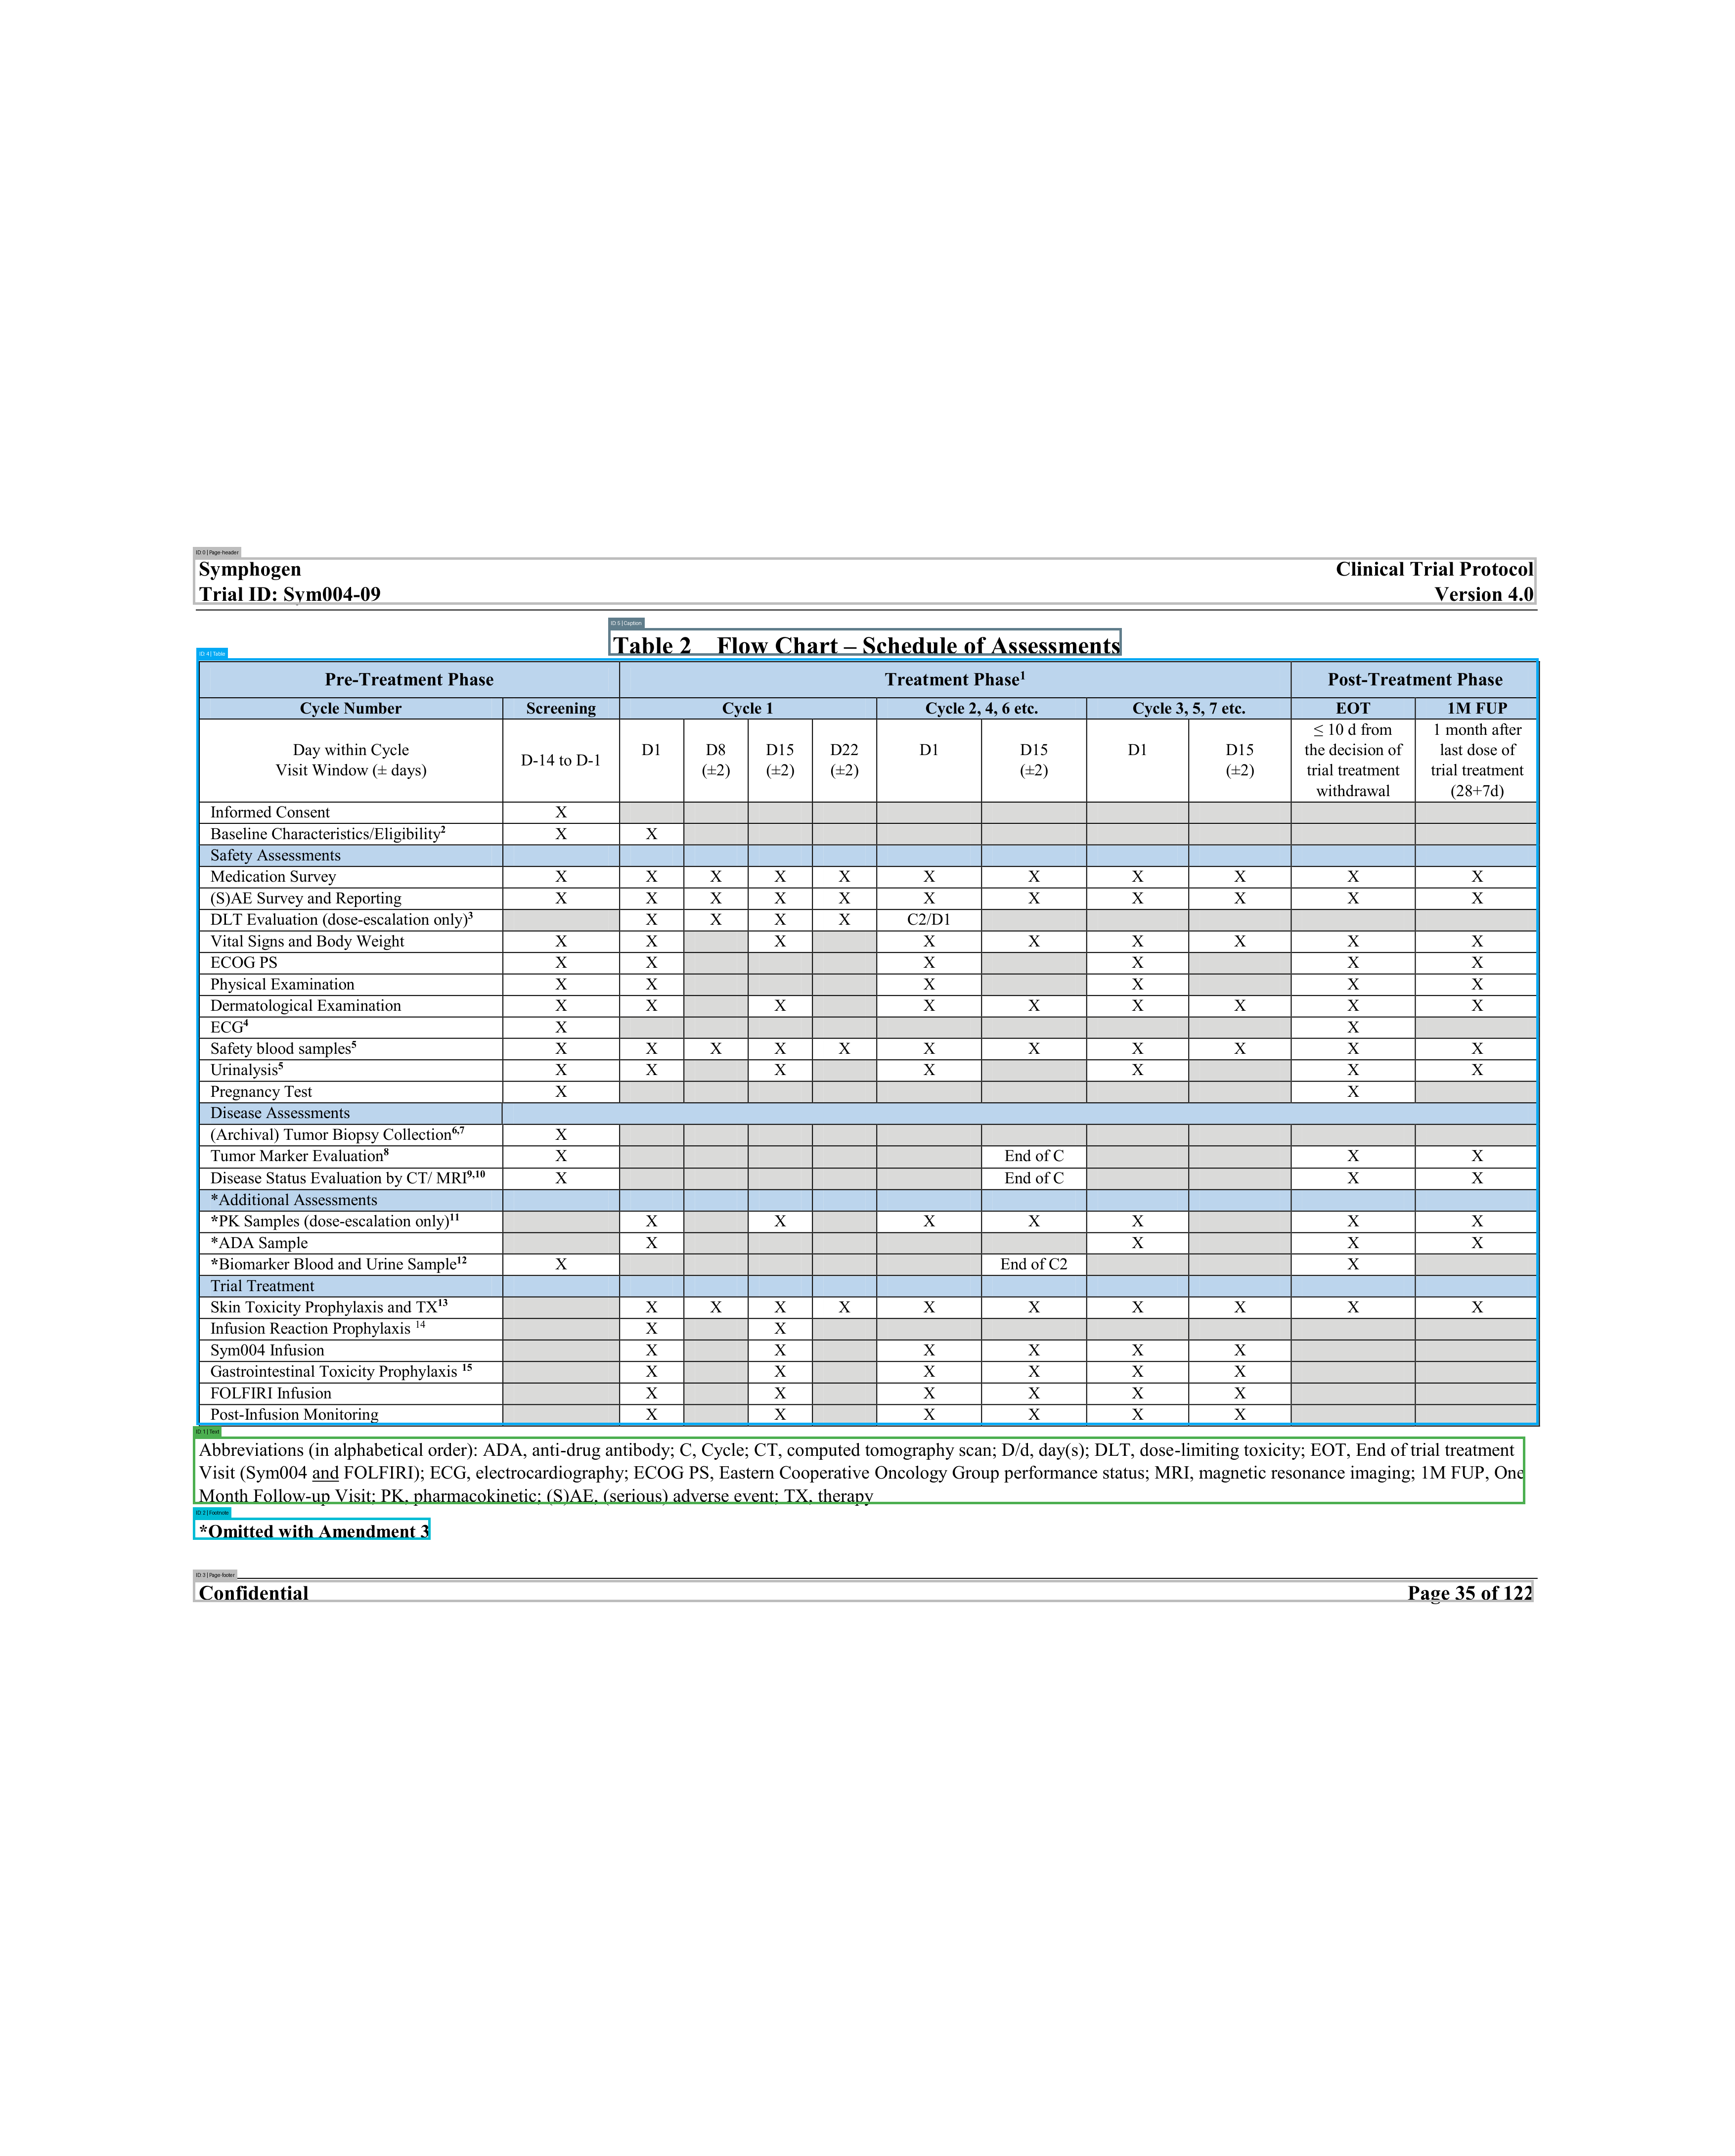

In [10]:
from PIL import Image
import os

# Load the annotated image
annotated_image_path = "output_results/annotated_images/soa_1_page_1_fitz_resized_annotated.png"
annotated_image = Image.open(annotated_image_path)
annotated_image.show()


### Display Eclair extracted text

In [11]:
eclair_extracted_text_path = "output_results/json_outputs/soa_1_page_1_fitz_resized_extracted.json"
with open(eclair_extracted_text_path, 'r') as f:
    eclair_extracted_text = json.load(f)

print(json.dumps(eclair_extracted_text, indent=4))

{
    "source_document": "output_results/resized_images/soa_1_page_1_fitz_resized.png",
    "source_page_number": 0,
    "processing_timestamp_utc": "2025-10-14T16:08:02.100065+00:00",
    "status": "Layout extraction successful (Docker Inference)",
    "content": [
        {
            "extraction_id": 0,
            "metadata": {
                "source_page": 0,
                "type": "Page-header",
                "bbox": {
                    "xmin": 0.1113,
                    "ymin": 0.2586,
                    "xmax": 0.8857,
                    "ymax": 0.2805
                }
            },
            "confidence": "N/A",
            "extraction_status": "Success",
            "data": {
                "type": "textual",
                "content": "**Clinical Trial Protocol Version 4.0** **Symphogen **Trial ID: Sym004-09**"
            }
        },
        {
            "extraction_id": 1,
            "metadata": {
                "source_page": 0,
                "type": 

We can look at the extracted items one by one

In [12]:
idx = 0
item = eclair_extracted_text["content"][idx]
print("Item ID: ", item['extraction_id'])
print("Item Type: ", item['data']['type'])
print("Item Content: ", item['data']['content'])


Item ID:  0
Item Type:  textual
Item Content:  **Clinical Trial Protocol Version 4.0** **Symphogen **Trial ID: Sym004-09**


In [13]:
idx = 1
item = eclair_extracted_text["content"][idx]
print("Item ID: ", item['extraction_id'])
print("Item Type: ", item['data']['type'])
print("Item Content: ", item['data']['content'])

Item ID:  1
Item Type:  textual
Item Content:  Abbreviations (in alphabetical order): ADA, anti-drug antibody; C, Cycle; CT, computed tomography scan; D/d, day(s); DLT, dose-limiting toxicity; EOT, End of trial treatment Visit (Sym004 and FOLFIRI); ECG, electrocardiography; ECOG PS, Eastern Cooperative Oncology Group performance status; MRI, magnetic resonance imaging; 1M FUP, One Month Follow-up Visit; PK, pharmacokinetic; (S)AE, (serious) adverse event; TX, therapy


In [14]:
idx = 2
item = eclair_extracted_text["content"][idx]
print("Item ID: ", item['extraction_id'])
print("Item Type: ", item['data']['type'])
print("Item Content: ", item['data']['content'])

Item ID:  2
Item Type:  textual
Item Content:  **Omitted with Amendment 3


In [15]:
idx = 3
item = eclair_extracted_text["content"][idx]
print("Item ID: ", item['extraction_id'])
print("Item Type: ", item['data']['type'])
print("Item Content: ", item['data']['content'])

Item ID:  3
Item Type:  textual
Item Content:  Confidential Page 35 of 122


In [16]:
idx = 5
item = eclair_extracted_text["content"][idx]
print("Item ID: ", item['extraction_id'])
print("Item Type: ", item['data']['type'])
print("Item Content: ", item['data']['content'])

Item ID:  5
Item Type:  textual
Item Content:  **Table 2 Flow Chart – Schedule of Assessments**


### Display Eclair extracted tables

In [17]:
idx = 4
item = eclair_extracted_text["content"][idx]
print("Item ID: ", item['extraction_id'])
print("Item Type: ", item['data']['type'])

# when type is `tabular`, we need to display the HTML table
display(HTML(item['data']['content_html']))

Item ID:  4
Item Type:  tabular


#### Inspecting merged columns

Notes on table conversion: 
1. Some text format styles might be removed during table conversion. 
2. Visually inspecting location of merged columns/cells isn't reliable. We need to look into the HTML code.

To do this, first, we export HTML code a file, so we can look at it


In [18]:
# write the html table to a file for inspecting 
os.makedirs('output_results/html_tables', exist_ok=True)
with open('output_results/html_tables/soa_1_page_1_fitz_resized_extracted.html', 'w') as f:
    f.write(item['data']['content_html'])

For merged columns, look for the `<td colspan="2">` tag. 


**Example 1**: 

look at the `soa_1_page_1_fitz_extracted.html` file we exported above. Find this line: 
```html
<tr>
    <td colspan="2"><b>Pre-Treatment Phase</b></td>
    <td colspan="8"><b>Treatment Phase1</b></td>
    <td colspan="3"><b>Post-Treatment Phase</b></td>
</tr>
```

The `colspan` is the number of column units that this header spans across. For example: 

1. `Pre-Treatment Phase` spans 2 columns, meaning that it covers these columns: 
    -  `Day within Cycle Visit Window (± days)`
    - `D-14 to D-1` 
2. `Treatment Phase1` spans 8 columns, meaning that it covers these columns: 
    - `D1`
    - `D8 (±2)`
    - `D15 (±2)`
    - `D22 (±2)`
    - `D1`
    - `D15 (±2)`
    - `D1`
    - `D15 (±2)`
3. `Post-Treatment Phase` spans 3 columns, meaning that it covers these columns: 
    - `≤ 10 d from the decision of trial treatment withdrawal`
    - `1 month after last dose of trial treatment (28+7d)`
    - a column with empty header at the end of the table (this was incorrectly generated)


**Example 2**: 

Find this block in the same file above: 

```html
<tr>
    <td><b>Cycle Number</b></td>
    <td><b>Screening</b></td>
    <td colspan="4"><b>Cycle 1</b></td>
    <td colspan="2"><b>Cycle 2, 4, 6 etc.</b></td>
    <td colspan="2"><b>Cycle 3, 5, 7 etc.</b></td>
    <td><b>EOT</b></td>
    <td><b>1M FUP</b></td>
</tr>
```

We can see that: 
- `Cycle Number` spans 1 column. It covers: 
    - `Day within Cycle Visit Window (± days)`
- `Screening` spans 1 column. It covers: 
    - `D-14 to D-1` 
- `Cycle 1` spans 4 columns, It covers: 
    - `D1`
    - `D8 (±2)`
    - `D15 (±2)`
    - `D22 (±2)`
- `Cycle 2, 4, 6 etc.` spans 2 colums. It covers: 
    - `D1`
    - `D15 (±2)`
- `Cycle 3, 5, 7 etc.` spans 2 columns. It covers: 
    -  `D1`
    - `D15 (±2)`
- `EOT` spans 1 column. It covers: 
    - `≤ 10 d from the decision of trial treatment withdrawal`
- `1M FUP` spans 1 column. It covers: 
    - `1 month after last dose of trial treatment (28+7d)`

So even though the HTML displays the headers a bit skrewed (possibly due to alignment settings), the actual column grouping is correct (except for the last extra column without header)


#### Inspect merged rows

Similarly to colspan, merged rows are displayed with `rowspan` tag, like this: 
```html
<th rowspan="2">SOME WORDS HERE</th>
```


```html
```